# 데이터 준비

28577_36420_compressed_fer2013.csv.zip 파일을 https://www.kaggle.com/deadskull7/fer2013 에서 다운 받은 후에 google drive의 tmp(미리 생성한)폴더에 올린다.


데이터 로딩하고 준비하는 코드는 https://github.com/SagarPatel98/Human-Facial-Emotion-Recognition---Keras/blob/master/Facial%20Recognition.ipynb 에서 가져왔다.

## 다운로드

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp '/content/drive/MyDrive/tmp/archive.zip' ./

In [5]:
!unzip archive.zip

Archive:  archive.zip
  inflating: fer2013.csv             


## 살펴보기

In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from matplotlib.colors import ListedColormap
import seaborn as sns

import cv2

In [7]:
df = pd.read_csv("fer2013.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
print(df.shape)

(35887, 3)


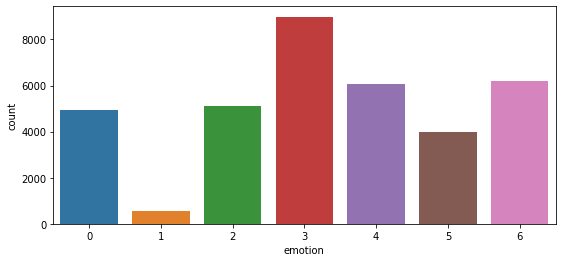

In [9]:
plt.figure(figsize=(9,4))
sns.countplot(x='emotion', data=df)

In [10]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

emotion 컬럼의 값은 다음을 의미.

0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

1(disgust)의 수가 너무 적다.

0(angry)와 1(disgust)를 합친다.

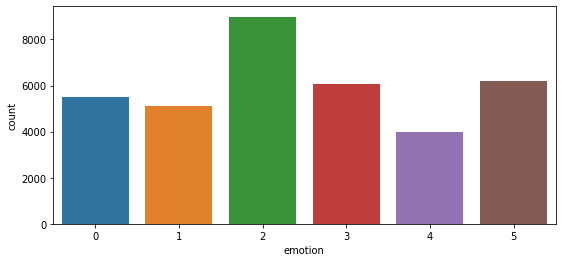

In [11]:
df['emotion'] = df['emotion'].map( {0:0, 1:0, 2:1, 3:2, 4:3, 5:4, 6:5} ).astype(int)
plt.figure(figsize=(9,4))
sns.countplot(x='emotion', data=df)

In [12]:
category_names = [ "angry", "fear", "happy", "sad", "suprise", "neutral" ]

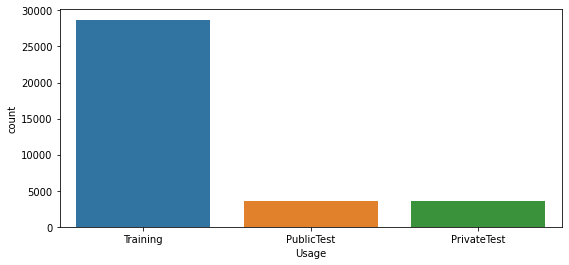

In [13]:
plt.figure(figsize=(9,4))
sns.countplot(x='Usage', data=df)

In [14]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

## 얼굴 데이터 구하기

받은 csv파일에 얼굴 영상의 pixel 값이 숫자로 그냥 들어 있다.
이를 읽어서 데이터를 준비하자.

In [15]:
image_size=(48,48)

In [16]:
pixels = df['pixels'].tolist()
width, height = 48, 48
faces = []

for pixel_sequence in pixels:
  face = [int(pixel) for pixel in pixel_sequence.split(' ')]
  face = np.asarray(face).reshape(width, height)
  face = cv2.resize(face.astype('uint8'),image_size)
  faces.append(face.astype('float32'))
  
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
print(faces.shape)

(35887, 48, 48, 1)


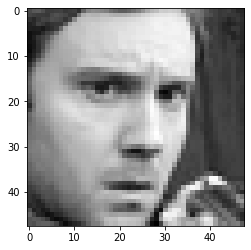

In [17]:
plt.imshow(faces[0].squeeze(), cmap="gray")

## Normalization

In [18]:
print(np.min(faces), np.max(faces))
faces = faces / 255.0
print(np.min(faces), np.max(faces))

0.0 255.0
0.0 1.0


## emotion 데이터 구하기

In [19]:
emotions = df['emotion'].values
print(emotions.shape)
print(emotions)

(35887,)
[0 0 1 ... 0 2 1]


## 데이터 나누기

In [20]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(faces, emotions, test_size=0.2)

In [21]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(28709, 48, 48, 1)
(28709,)
(7178, 48, 48, 1)
(7178,)


# 모델 정의

In [22]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPool2D, Input
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array


model = keras.Sequential()

model.add(Input(train_x.shape[1:]))
model.add(Conv2D(32, (3,3), padding="same"))
model.add(MaxPool2D())
model.add(Conv2D(64, (3,3), padding="same"))
model.add(MaxPool2D())
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])



# 데이터 증강

In [23]:
train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
)

test_data_generator = ImageDataGenerator()

# 학습

In [24]:
model.fit(
      train_data_generator.flow(train_x, train_y, 32),
      validation_data=test_data_generator.flow(test_x, test_y, 32),
      steps_per_epoch=len(train_x)/32,  
      validation_steps=len(test_x)/32,      
      epochs=10
)

Epoch 1/10
897/897 [==============================] - 25s 15ms/step - loss: 1.6741 - acc: 0.3233 - val_loss: 1.4137 - val_acc: 0.4447
Epoch 2/10
897/897 [==============================] - 13s 15ms/step - loss: 1.5077 - acc: 0.4030 - val_loss: 1.4401 - val_acc: 0.4501
Epoch 3/10
897/897 [==============================] - 13s 15ms/step - loss: 1.4625 - acc: 0.4266 - val_loss: 1.3828 - val_acc: 0.4650
Epoch 4/10
897/897 [==============================] - 13s 15ms/step - loss: 1.4371 - acc: 0.4392 - val_loss: 1.3073 - val_acc: 0.4930
Epoch 5/10
897/897 [==============================] - 13s 15ms/step - loss: 1.4186 - acc: 0.4485 - val_loss: 1.3161 - val_acc: 0.4983
Epoch 6/10
897/897 [==============================] - 13s 15ms/step - loss: 1.4143 - acc: 0.4463 - val_loss: 1.3268 - val_acc: 0.4801
Epoch 7/10
897/897 [==============================] - 13s 15ms/step - loss: 1.4165 - acc: 0.4492 - val_loss: 1.3106 - val_acc: 0.5091
Epoch 8/10
897/897 [==============================] - 14s 15ms

# 평가

In [25]:
loss, acc = model.evaluate(
      test_data_generator.flow(test_x, test_y, 32),
      steps=len(test_x)/32
)
print(loss, acc)

224/224 [==============================] - 1s 4ms/step - loss: 1.3354 - acc: 0.5047
1.33540940284729 0.5047367215156555


# 결과 보기

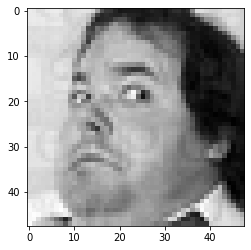

predicted category index = 2
happy


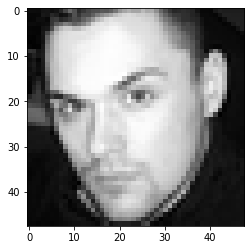

predicted category index = 5
neutral


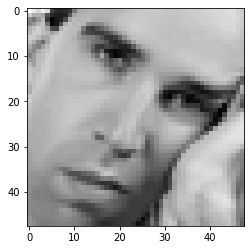

predicted category index = 3
sad


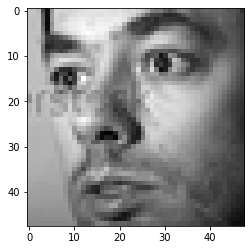

predicted category index = 5
neutral


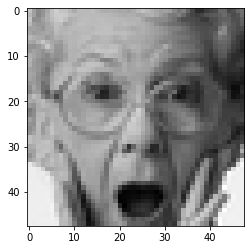

predicted category index = 4
suprise


In [26]:
y_ = model.predict(test_x)

predicted = np.argmax(y_, axis=1)

for i in range(5):
  plt.imshow(test_x[i].squeeze(), cmap="gray")
  plt.show()
  print("predicted category index =", predicted[i])
  print(category_names[predicted[i]])
